In [23]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [51]:
batch_size = 100

In [52]:
train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor()
)
train_loader = DataLoader(
    train_set, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2
)

test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=ToTensor()
)
test_loader = DataLoader(
    test_set, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2
)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [48]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([10, 1, 28, 28])
Shape of y: torch.Size([10]) torch.int64


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [19]:
def images_show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

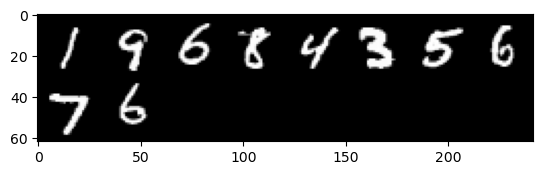

1     9     6     8     4     3     5     6     7     6    


In [49]:
# Getting random images
data_iter = iter(train_loader)
images, y = next(data_iter)

# show images
images_show(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[y[j]]:5s}' for j in range(batch_size)))

## Define a Convolutional Neural Network

In [29]:
import torch.nn as nn
import torch.nn.functional as F

In [44]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_stack = nn.Sequential(
            # [1, 28, 28]
            nn.Conv2d( 
                in_channels=1, 
                out_channels=3, 
                kernel_size=3
            ),
            # [3, 26, 26]
            nn.MaxPool2d(
                kernel_size=2, 
                stride=2
            ),
            # [3, 13, 13]
            nn.Conv2d(
                in_channels=3,
                out_channels=6,
                kernel_size=4
            ),
            # [6, 10, 10]
            nn.MaxPool2d(
                kernel_size=2, 
                stride=2
            ),
            # [6, 5, 5]
            nn.Flatten(),
            # [1, 6*5*5]
            nn.Linear(
                in_features=6*5*5, 
                out_features=120
            ),
            # [1, 120]
            nn.ReLU(),
            nn.Linear(
                in_features=120, 
                out_features=60
            ),
            # [1, 60]
            nn.ReLU(),
            nn.Linear(
                in_features=60, 
                out_features=10
            )
            # [1, 10]
        )
    
    def forward(self, x):
        x = self.layers_stack(x)
        return x

In [35]:
model = CNN()

## Define a Loss function and an Optimizer

In [36]:
import torch.optim as optim

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Train the network

### Define the train function

In [57]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(train_loader.dataset)
    model.train()
    for i, data in enumerate(dataloader):
        # data is a list of [inputs, labels]
        X, y = data

        # forward-pass
        pred = model(X)

        # calculate loss
        loss = loss_fn(pred, y)

        # backward-pass
        loss.backward()

        # optimize
        optimizer.step()

        # zero out all the parameter gradients
        optimizer.zero_grad()

        if i % 100 == 0:
            loss, current = loss.item(), (i + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Define the test function

In [54]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Train the model

In [58]:
for i in range(5):
    print(f"Epoch {i+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print('Finished Training')
        

Epoch 1
-------------------------------
loss: 2.285802  [  100/60000]
loss: 2.278128  [10100/60000]
loss: 2.245514  [20100/60000]
loss: 2.191175  [30100/60000]
loss: 2.025853  [40100/60000]
loss: 1.611917  [50100/60000]
Test Error: 
 Accuracy: 72.5%, Avg loss: 0.947556 

Epoch 2
-------------------------------
loss: 1.013390  [  100/60000]
loss: 0.796260  [10100/60000]
loss: 0.566981  [20100/60000]
loss: 0.623187  [30100/60000]
loss: 0.437380  [40100/60000]
loss: 0.379730  [50100/60000]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.332342 

Epoch 3
-------------------------------
loss: 0.260117  [  100/60000]
loss: 0.308841  [10100/60000]
loss: 0.277020  [20100/60000]
loss: 0.231280  [30100/60000]
loss: 0.204370  [40100/60000]
loss: 0.243910  [50100/60000]
Test Error: 
 Accuracy: 92.5%, Avg loss: 0.248398 

Epoch 4
-------------------------------
loss: 0.378507  [  100/60000]
loss: 0.282332  [10100/60000]
loss: 0.116348  [20100/60000]
loss: 0.336066  [30100/60000]
loss: 0.255441  [40100/6

### Check accuracy of the classified types

In [59]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            pred = pred.argmax(1)
            for label, prediction in zip(y, pred):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 99.3 %
Accuracy for class: 1     is 98.6 %
Accuracy for class: 2     is 93.4 %
Accuracy for class: 3     is 94.6 %
Accuracy for class: 4     is 94.1 %
Accuracy for class: 5     is 94.7 %
Accuracy for class: 6     is 96.0 %
Accuracy for class: 7     is 92.7 %
Accuracy for class: 8     is 91.3 %
Accuracy for class: 9     is 92.5 %
